In [10]:
# импортируем либы

import pandas as pd
import numpy as np
import pandahouse as ph
from datetime import date
import holidays
from fbprophet import Prophet

In [11]:
# Объявим параметры подключения к clickhouse
connection = dict(database='test',   #Объявляем какую хотим подключить базу данных в нашем случае - test
                          host='http://clickhouse.lab.karpov.courses', #Объявляем ссылку на кликхаус от куда подгружаем
                          user='*********', #Объявляем логин
                          password='*********') #Объявляем пароль для доступа

In [17]:
# Вкидываем данные (первый столбец - даты(ds), второй - уники(y))
query = """
SELECT      --Пишем запрос, подгружаем столбцы в клиикхаусе
    ds,     --Столбец
    uniqExact(DeviceID) AS y --Ищем уников с помощью iniqExact() по колонке
FROM test.installs --подгружаем саму таблицу
WHERE              --Фильтруем по заданным условиям
    Source = 'Source_27' --Фильтруем и ищем только по значнию в колонке source
    AND InstallCost = 0  --Второе условие А ТАК ЖЕ колокеа должна ровняться нулю
GROUP BY CAST(InstallationDate AS Date) as ds --группируем колонку и тут же преобразуем из типа данных String в datetime
ORDER BY ds ASC --Фильтруем по возрастанию 
"""
df = ph.read_clickhouse(query, connection=connection) #В новую переменную пишем библиотеку ph и читаем данные с кликхаус
                                                      #Далее в скобки передаём переменную с нашим запросом к кликхаусу
                                                      #И как устанавливаем коннект с кликхаусом
df['ds'] = pd.to_datetime(df.ds)
df

,ds,y
0,2019-01-01,26243
1,2019-01-02,31303
2,2019-01-03,34017
3,2019-01-04,33807
4,2019-01-05,33925
...,...,...
272,2019-09-30,19028
273,2019-10-01,19176
274,2019-10-02,18926
275,2019-10-03,18373


In [19]:
# Вкидываем праздники, для их учёта моделькой
# Так же fcebook Prophet допускает учитывать праздничные дни того, что бы посмотреть
# в какие праздничные дни у нас допустим приод больше, а какие праздники он у нас меньше
# например - новый год, потребляют люди больше, или меньше
holidays_dict = holidays.RU(years=(2015, 2016, 2017, 2018, 2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index': 'ds', 0: 'holiday'}, axis='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()
# ЭТО ПРАЗДНИЧНЫЙ ШАБЛОН И ИМ МОЖНО БЕЗОШИБОЧНО ПОЛЬЗОВАТЬСЯ В БУДУЩЕМ!!!

,ds,holiday
93,2021-03-08,День женщин
94,2021-05-01,Праздник Весны и Труда
95,2021-05-09,День Победы
96,2021-06-12,День России
97,2021-11-04,День народного единства


Теперь мы будем проверять нашу точность на последних 30-ти днях, мы возьмём последние 30 дней и отрежем их от нашего датафрема
предскажем эти 30 дней Prophet и сравним с тем, что у нас предсказалось и что у нас было на самом деле.
Объявим параметр что мы хотим отрезать 30 дней:

In [20]:
# Период который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, что бы измерить на них качество
train_df = df[:-predictions]

далее мы зовём Prophet и передаём ему параметры, мы говормим ему что наши праздники лежат в df_holidays, 
мы говорим что daily_seasonality у нас отключена = False, это сезонность внутри дня, это еслибы данные были
почасовые, поминутные, посекундные.
мы говорим что yearly_seasonality у нас выключена = False, а weekly_seasonality включениа = True,
Мы выключили yearly_seasonality(сезонность внутри года) потому что у нас мало данных о полной сезонности внутри года, 
если этот параметр отключить, то Prophet будет вести себя гораздо точнее



In [26]:
# Зовём Prophet - говорим ему учитывать праздники и сезонности
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
m.fit(train_df)

In [29]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

Далее посмотрим предсказание
Там - где чёрные точки есть, это факт, там где их нет - это предсказание

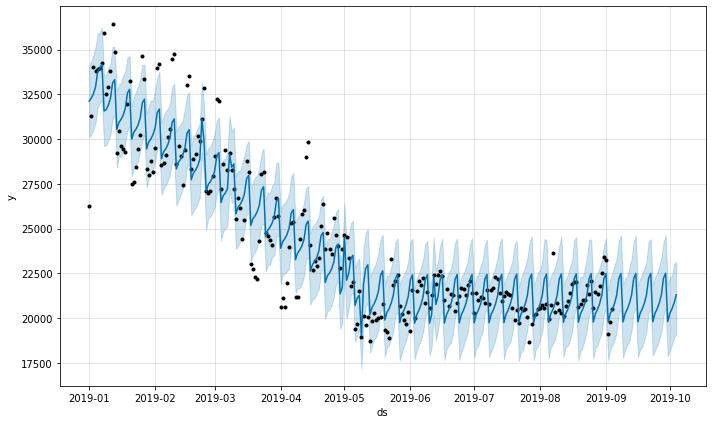

In [30]:
# Смотрим, что предсказалось
m.plot(forecast);

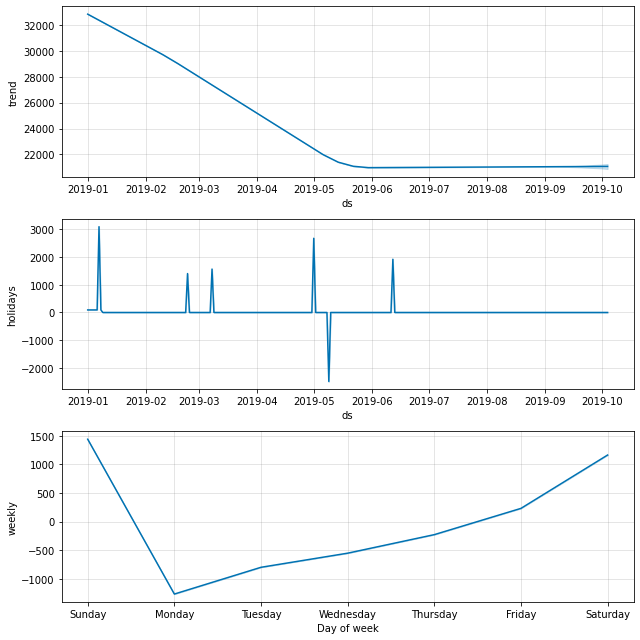

In [31]:
# Смотрим на сезонности
m.plot_components(forecast);

Далее мы можем нарисовать интеракивных график с границами прогноза, нарисуем:

In [33]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
        go.Scatter(x=df['ds'], y=df['y'], name='fact'),
        go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
        go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
        go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
        go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [37]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в поцентах) -', np.mean(abs(cmp_df[-predictions:]['p'])), '%')
print('MAPE (средняя абсолютная ошибка) -', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в поцентах) - 5.563714061132858 %
MAPE (средняя абсолютная ошибка) - 1079.6766978168882


In [39]:
# прогнозируем полный период (указываем колличество дней)
prediction_days = 180
final_train_df = df
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

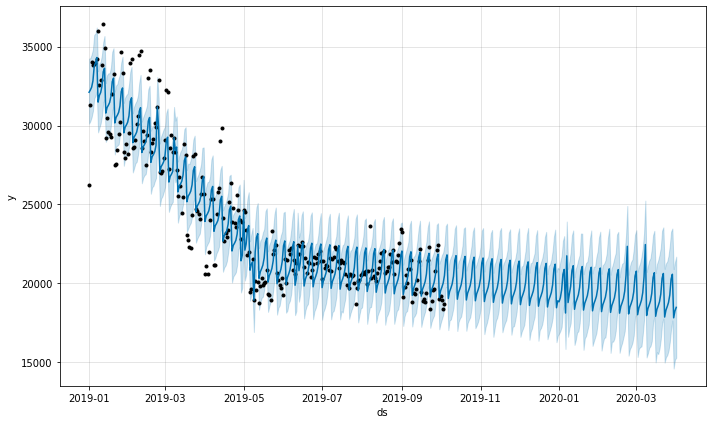

In [43]:
# Смотрим что предсказалоь на полный период
f.plot(final_forecast);

In [44]:
# рисуемм график с границами прогноза на полном периоде
iplot([
        go.Scatter(x=df['ds'], y=df['y'], name='fact'),
        go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yahat'),
        go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
        go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
        go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [46]:
# выгружаемм наш прогноз в excel. Спрогнозированное значение у нас лежит в yahat.
final_forecast.to_excel("./app_forecast.xlsx", sheet_name='Data', index=False, encoding='cp1251')